### Setup

In [ ]:
!pip install pyyaml==5.4.1

In [ ]:
import pandas as pd
import plotly.express as px

import tensorflow as tf

## Data and Preprocessing

### Raw data

In [ ]:
base_path = "/content/drive/MyDrive/CSE 635: Final Project/data/task_1/"

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

base_path = ""

In [ ]:
df_train = pd.read_csv(base_path + "task_1_information_extraction_train_20k.csv")
df_valid = pd.read_csv(base_path + "task_1_information_extraction_valid_5k.csv")
df_train.head()

,NOTES,EVENT_DATE,SOURCE,FATALITIES,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,LOCATION
0,Three people were killed while 27 others injur...,29-August-2012,Statesman (Pakistan),3,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Pakistan),3,Civilians (Pakistan),7,37,Jacobabad
1,Government security forces opened fire at a pr...,03-May-2014,Undisclosed Source,0,Violence against civilians,Attack,Military Forces of Somalia (2012-2017),1,Civilians (Somalia),7,17,Baidoa
2,Al Shabaab forces attacked government forces b...,01-May-2012,All Africa,11,Battles,Armed clash,Al Shabaab,2,Military Forces of Somalia (2004-2012),1,12,Hudur
3,Agreement: Rebels resumed peace talks with the...,05-October-2013,AFP,0,Strategic developments,Agreement,MNLA: National Movement for the Liberation of ...,2,Government of Mali (2013-2020),1,12,Bamako
4,The person who had acted as the go-between for...,21-December-2001,Dispatch Kabylie,0,Riots,Violent demonstration,Rioters (Algeria),5,NaN,0,50,Bejaia


In [ ]:
df_train.info()
list(df_train.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   NOTES           19420 non-null  object
 1   EVENT_DATE      20000 non-null  object
 2   SOURCE          20000 non-null  object
 3   FATALITIES      20000 non-null  int64 
 4   EVENT_TYPE      20000 non-null  object
 5   SUB_EVENT_TYPE  20000 non-null  object
 6   ACTOR1          20000 non-null  object
 7   INTER1          20000 non-null  int64 
 8   ACTOR2          14904 non-null  object
 9   INTER2          20000 non-null  int64 
 10  INTERACTION     20000 non-null  int64 
 11  LOCATION        20000 non-null  object
dtypes: int64(4), object(8)
memory usage: 1.8+ MB


['NOTES',
 'EVENT_DATE',
 'SOURCE',
 'FATALITIES',
 'EVENT_TYPE',
 'SUB_EVENT_TYPE',
 'ACTOR1',
 'INTER1',
 'ACTOR2',
 'INTER2',
 'INTERACTION',
 'LOCATION']

### Visualizing the Data


In [ ]:

# Color map for each class to keep the chart colors consistent
color_map = {
    'Protests': '#f7d6d6',
    'Riots': '#FFA694',
    'Battles': '#FADCB4',
    'Violence against civilians': '#ffb347',
    'Strategic developments': '#f5f5dd',
    'Explosions/Remote violence': '#ff6962'
}

event_counts = df_train['EVENT_TYPE'].value_counts().reset_index(name="count")

fig = px.pie(
    event_counts,
    names="index",
    values="count",
    title="Events",
    template=dict(
        layout=dict(
            title_x=0.5
        )
    ),
    color_discrete_map=color_map,
    color="index"
)

fig.update_traces(textposition='auto', texttemplate='<b>%{label}</b> <br />%{value}', hovertemplate="%{value} %{label}")
fig.update_layout(margin = dict(l=0, r=0, b=0))
fig.show()

In [ ]:
def get_counts_breakup(path):
    event_counts_breakup = df_train.groupby(path).size().reset_index(name="count")

    fig = px.sunburst(
        event_counts_breakup,
        path=path,
        values='count',
        color_discrete_map=color_map,
        color=path[0],
        height=700
    )
    fig.update_traces(texttemplate='<b>%{label}</b> <br /> %{value} Events', hovertemplate="%{label} - %{value} Events")
    fig.update_layout(margin = dict(l=0, r=0, b=0),showlegend=True, title="Events - Distribution by <b>Count</b>", title_x=0.5)
    fig.show()

get_counts_breakup(['EVENT_TYPE', 'SUB_EVENT_TYPE'])

In [ ]:
get_counts_breakup(['INTER1', 'INTER2']) 

In [ ]:
get_counts_breakup(['EVENT_TYPE', 'INTER1']) 

### Processing

#### drop empty notes rows

In [ ]:
is_not_zero = lambda x: x!=0 # Function to return True if value is not zero
df_train.isna().sum().where(is_not_zero).dropna()

NOTES      580.0
ACTOR2    5096.0
dtype: float64

In [ ]:
df_train = df_train[df_train['NOTES'].notna()]
df_valid = df_valid[df_valid['NOTES'].notna()]

In [ ]:
len(df_train), len(df_valid)

(19420, 4869)

#### Prep feature and target variables

In [ ]:
# Features
notes_train, notes_valid = df_train['NOTES'], df_valid['NOTES']
notes_train[3]

'Agreement: Rebels resumed peace talks with the Malian government for the first time since September 26th.'

In [ ]:
# Target
event_type_int_map = {s: idx for idx, s in enumerate(df_train['EVENT_TYPE'].factorize()[1])}
print(event_type_int_map)
num_classes = len(event_type_int_map)
df_train['EVENT_TYPE'] = df_train['EVENT_TYPE'].replace(event_type_int_map)
df_valid['EVENT_TYPE'] = df_valid['EVENT_TYPE'].replace(event_type_int_map)

# y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)
target_train = tf.keras.utils.to_categorical(df_train['EVENT_TYPE'].values, num_classes=num_classes)
target_valid = tf.keras.utils.to_categorical(df_valid['EVENT_TYPE'].values, num_classes=num_classes)

df_train['EVENT_TYPE'], target_train

{'Explosions/Remote violence': 0, 'Violence against civilians': 1, 'Battles': 2, 'Strategic developments': 3, 'Riots': 4, 'Protests': 5}


(0        0
 1        1
 2        2
 3        3
 4        4
         ..
 19995    5
 19996    2
 19997    2
 19998    5
 19999    5
 Name: EVENT_TYPE, Length: 19420, dtype: int64,
 array([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.]], dtype=float32))

In [ ]:
print(notes_train.shape, target_train.shape)
print(notes_valid.shape, target_valid.shape)
# print(newsgroups_test.target.shape, newsgroups_test.target.shape)

(19420,) (19420, 6)
(4869,) (4869, 6)


## BERT

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 8.1 MB/s 
     |████████████████████████████████| 462 kB 51.9 MB/s 


In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text


tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

# preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
# encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

preprocessor = hub.KerasLayer(tfhub_handle_preprocess)  # bert_preprocess_model
encoder = hub.KerasLayer(tfhub_handle_encoder)  # bert_model

### Try encoding text

In [ ]:
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

print(notes_train[3])
get_embeddings([notes_train[3]])

Agreement: Rebels resumed peace talks with the Malian government for the first time since September 26th.


<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 9.80098188e-01,  5.18456995e-01,  7.56245479e-02,
         3.01929533e-01, -4.63080518e-02,  7.48234093e-01,
         9.89595950e-01, -9.87496495e-01, -5.58306202e-02,
        -9.89190876e-01,  1.40807062e-01, -8.15477729e-01,
         1.97780594e-01, -9.90958035e-01, -8.30307066e-01,
         1.71105146e-01, -1.21638561e-02, -3.48519199e-02,
        -6.02742434e-01,  2.88040172e-02,  7.05707166e-03,
        -3.61453623e-01,  9.63865966e-02,  7.29770303e-01,
         9.97709930e-01,  7.76729941e-01, -4.15003806e-01,
        -3.63979906e-01,  7.68607110e-02,  3.70775759e-01,
         9.25985813e-01, -7.52983987e-02, -1.00484733e-02,
        -9.38063487e-04, -9.52462196e-01, -1.40243530e-01,
         1.10086381e-01,  5.11597209e-02,  9.72281516e-01,
        -3.84795249e-01, -3.87433857e-01, -1.12844005e-01,
         2.12825611e-01, -9.96648610e-01,  5.01687974e-02,
         9.86772656e-01, -2.41995111e-01,  3.90085995e-01,
      

In [ ]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


def plot_similarity(features, labels):
    """Plot a similarity matrix of the embeddings."""
    cos_sim = cosine_similarity(features)
    fig = plt.figure(figsize=(10,8))
    sns.set(font_scale=1.2)
    cbar_kws=dict(use_gridspec=False, location="left")
    g = sns.heatmap(
        cos_sim, xticklabels=labels, yticklabels=labels,
        vmin=0, vmax=1, annot=True, cmap="Blues", 
        cbar_kws=cbar_kws)
    g.tick_params(labelright=True, labelleft=False)
    g.set_yticklabels(labels, rotation=0)
    g.set_title("Semantic Textual Similarity")

In [ ]:
notes_train[-5:]

19995    On Thursday, BJP state president and his suppo...
19996    At around 03.00 in the night of 07-08/03/11 AS...
19997    The SPLM-N launched attacks on government posi...
19998    The residents of Khairpur protested outside th...
19999    Members of the ICU protest a proposed liquor b...
Name: NOTES, dtype: object

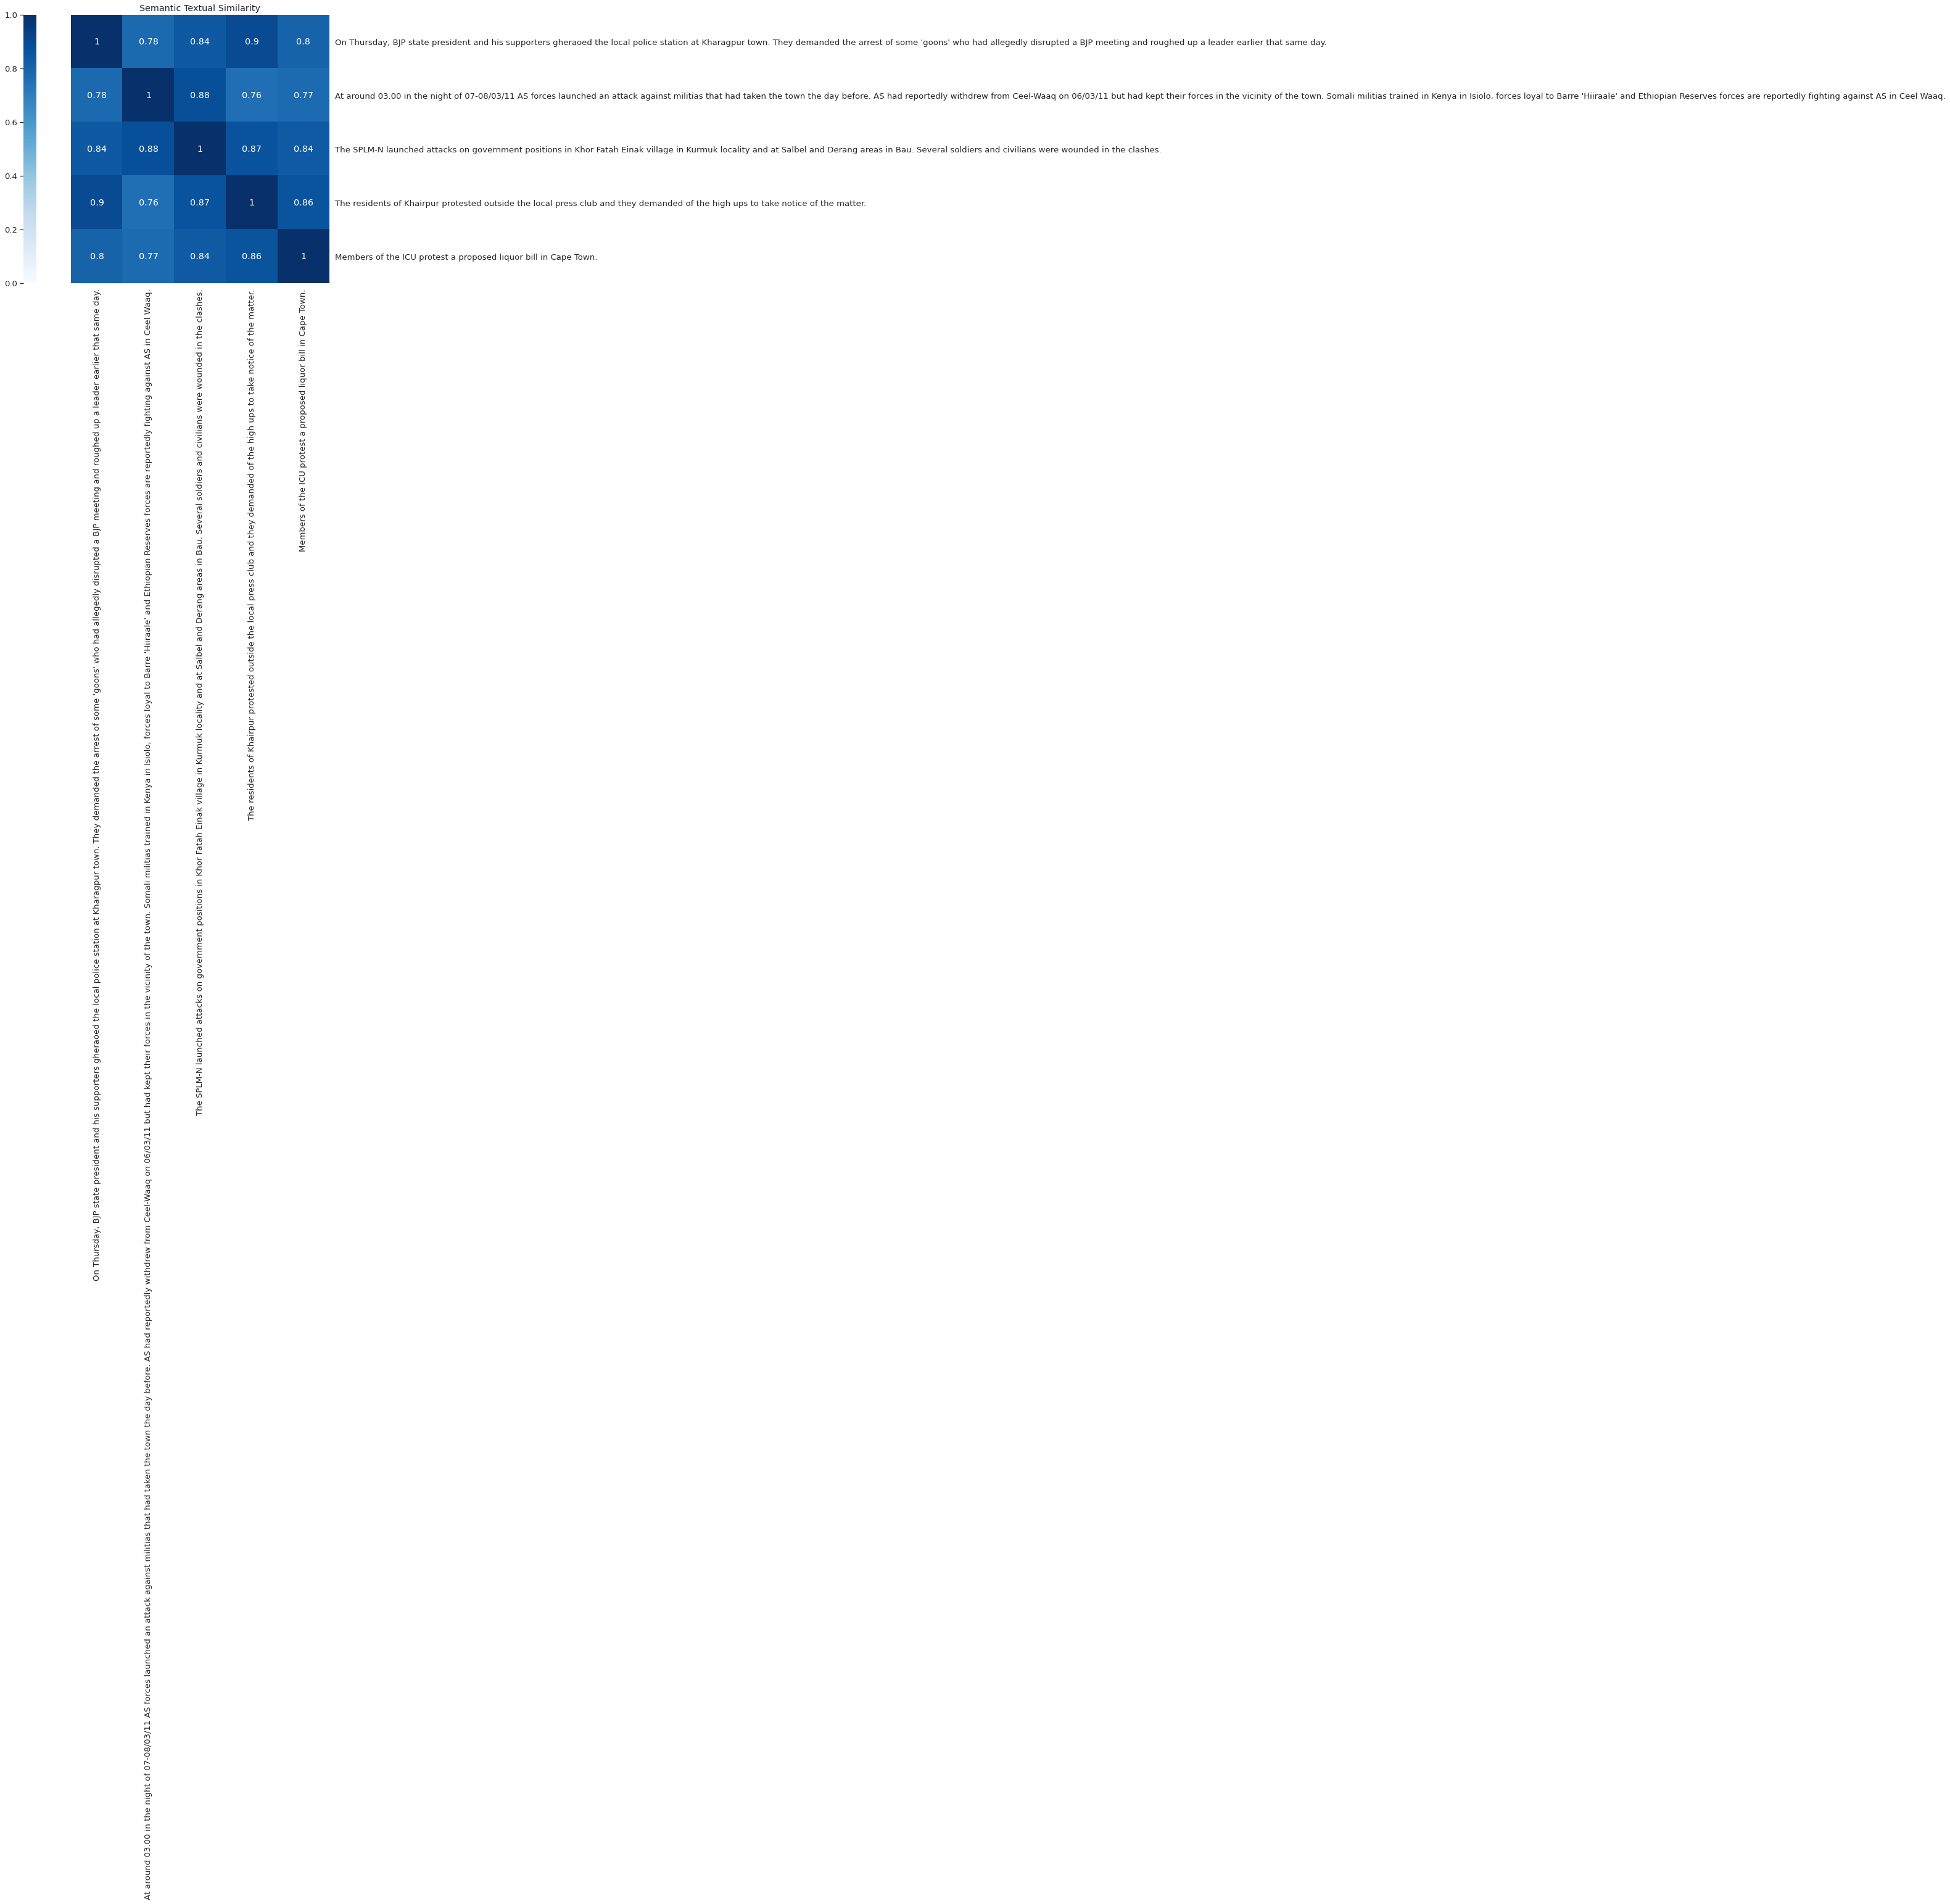

In [ ]:
# reviews = ["il libro è interessante",
#            "il romanzo è interessante",
#            "nel mezzo del cammin di nostra vita"]



plot_similarity(get_embeddings(notes_train[-5:]), notes_train[-5:])

## Classifier Model

### Metrics

In [ ]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

### Model

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(len(event_type_int_map), activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

### Training

In [ ]:
n_epochs = 5

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 90s 128ms/step - loss: 1.0458 - accuracy: 0.6030 - balanced_recall: 0.3140 - balanced_precision: 0.4509 - balanced_f1_score: 0.3658 - val_loss: 0.8587 - val_accuracy: 0.6695 - val_balanced_recall: 0.2865 - val_balanced_precision: 0.4157 - val_balanced_f1_score: 0.3353
Epoch 2/5
607/607 [==============================] - 76s 125ms/step - loss: 0.7961 - accuracy: 0.6965 - balanced_recall: 0.4678 - balanced_precision: 0.6011 - balanced_f1_score: 0.5237 - val_loss: 0.8276 - val_accuracy: 0.6543 - val_balanced_recall: 0.3302 - val_balanced_precision: 0.4383 - val_balanced_f1_score: 0.3729
Epoch 3/5
607/607 [==============================] - 89s 146ms/step - loss: 0.7451 - accuracy: 0.7113 - balanced_recall: 0.5070 - balanced_precision: 0.6319 - balanced_f1_score: 0.5605 - val_loss: 0.7701 - val_accuracy: 0.6852 - val_balanced_recall: 0.3448 - val_balanced_precision: 0.4131 - val_balanced_f1_score: 0.3718
Epoch 4/5
607/607 [===============

### Performance: Event

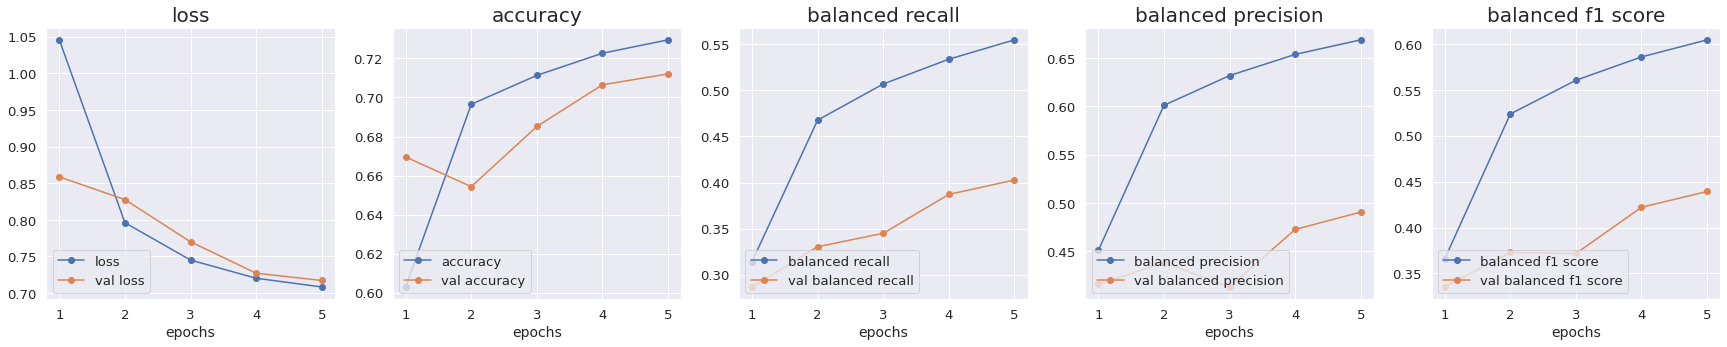

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

### Predict

In [ ]:
import numpy as np

def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]


# predict_class(reviews)

In [ ]:
# from sklearn.metrics import classification_report


# y_pred = predict_class(test_set["Text"])
# print(classification_report(test_set["Labels"], y_pred))

### Save

In [ ]:
model.save("multiclass_v1")

INFO:tensorflow:Assets written to: multiclass_v1/assets


INFO:tensorflow:Assets written to: multiclass_v1/assets


In [ ]:
!zip -r 'multiclass_v1.zip' 'multiclass_v1'

  adding: multiclass_v1/ (stored 0%)
  adding: multiclass_v1/assets/ (stored 0%)
  adding: multiclass_v1/assets/vocab.txt (deflated 53%)
  adding: multiclass_v1/saved_model.pb (deflated 92%)
  adding: multiclass_v1/keras_metadata.pb (deflated 84%)
  adding: multiclass_v1/variables/ (stored 0%)
  adding: multiclass_v1/variables/variables.index (deflated 75%)
  adding: multiclass_v1/variables/variables.data-00000-of-00001 (deflated 7%)


In [ ]:
import pickle

with open('multiclass_v1_history', 'wb') as file_pi:
    pickle.dump(model_fit.history, file_pi)

In [ ]:
from tensorflow import keras

# load model
new_model = keras.models.load_model("multiclass_v1", custom_objects = {"balanced_recall": balanced_recall, "balanced_precision": balanced_precision, "balanced_f1_score": balanced_f1_score})
# so, I think in order to deserialize the model more conveniently, these two metrics should subclass tf.keras.metrics.Metric

# test predictions
[np.argmax(pred) for pred in new_model.predict(notes_valid[-5:])]
# output: [3, 1, 0]

[1, 1, 1, 1, 1]

## sub event 

In [ ]:
# Target
event_type_int_map = {s: idx for idx, s in enumerate(df_train['SUB_EVENT_TYPE'].factorize()[1])}
print(event_type_int_map)
num_classes = len(event_type_int_map)
df_train['SUB_EVENT_TYPE'] = df_train['SUB_EVENT_TYPE'].replace(event_type_int_map)
df_valid['SUB_EVENT_TYPE'] = df_valid['SUB_EVENT_TYPE'].replace(event_type_int_map)

# y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)
target_train = tf.keras.utils.to_categorical(df_train['SUB_EVENT_TYPE'].values, num_classes=num_classes)
target_valid = tf.keras.utils.to_categorical(df_valid['SUB_EVENT_TYPE'].values, num_classes=num_classes)

{'Remote explosive/landmine/IED': 0, 'Attack': 1, 'Armed clash': 2, 'Agreement': 3, 'Violent demonstration': 4, 'Peaceful protest': 5, 'Mob violence': 6, 'Sexual violence': 7, 'Protest with intervention': 8, 'Arrests': 9, 'Grenade': 10, 'Abduction/forced disappearance': 11, 'Disrupted weapons use': 12, 'Government regains territory': 13, 'Air/drone strike': 14, 'Non-state actor overtakes territory': 15, 'Excessive force against protesters': 16, 'Shelling/artillery/missile attack': 17, 'Suicide bomb': 18, 'Headquarters or base established': 19, 'Looting/property destruction': 20, 'Change to group/activity': 21, 'Non-violent transfer of territory': 22, 'Other': 23}


In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(len(event_type_int_map), activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 5

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 84s 131ms/step - loss: 1.4867 - accuracy: 0.5831 - balanced_recall: 0.0665 - balanced_precision: 0.0944 - balanced_f1_score: 0.0766 - val_loss: 1.3047 - val_accuracy: 0.5876 - val_balanced_recall: 0.0528 - val_balanced_precision: 0.0749 - val_balanced_f1_score: 0.0607
Epoch 2/5
607/607 [==============================] - 95s 157ms/step - loss: 1.1534 - accuracy: 0.6272 - balanced_recall: 0.1021 - balanced_precision: 0.1277 - balanced_f1_score: 0.1127 - val_loss: 1.1814 - val_accuracy: 0.6112 - val_balanced_recall: 0.0736 - val_balanced_precision: 0.0936 - val_balanced_f1_score: 0.0813
Epoch 3/5
607/607 [==============================] - 81s 133ms/step - loss: 1.0634 - accuracy: 0.6476 - balanced_recall: 0.1184 - balanced_precision: 0.1445 - balanced_f1_score: 0.1294 - val_loss: 1.1225 - val_accuracy: 0.6153 - val_balanced_recall: 0.0778 - val_balanced_precision: 0.0917 - val_balanced_f1_score: 0.0832
Epoch 4/5
607/607 [===============

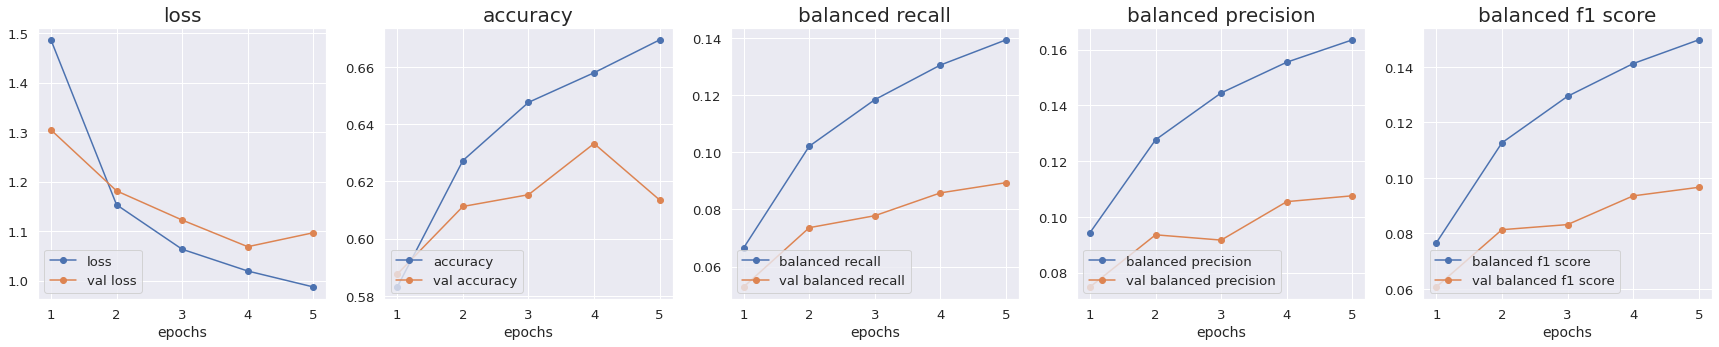

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

### Inter1

In [ ]:
# Target
# y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)
target_train = tf.keras.utils.to_categorical(df_train['INTER1'].values, num_classes=num_classes)
target_valid = tf.keras.utils.to_categorical(df_valid['INTER1'].values, num_classes=num_classes)

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(len(event_type_int_map), activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 5

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 87s 134ms/step - loss: 1.3005 - accuracy: 0.5239 - balanced_recall: 0.0573 - balanced_precision: 0.0925 - balanced_f1_score: 0.0695 - val_loss: 1.2741 - val_accuracy: 0.4818 - val_balanced_recall: 0.0377 - val_balanced_precision: 0.0742 - val_balanced_f1_score: 0.0473
Epoch 2/5
607/607 [==============================] - 78s 128ms/step - loss: 1.0902 - accuracy: 0.5746 - balanced_recall: 0.0858 - balanced_precision: 0.1307 - balanced_f1_score: 0.1026 - val_loss: 1.2149 - val_accuracy: 0.4997 - val_balanced_recall: 0.0493 - val_balanced_precision: 0.0866 - val_balanced_f1_score: 0.0608
Epoch 3/5
607/607 [==============================] - 77s 127ms/step - loss: 1.0512 - accuracy: 0.5895 - balanced_recall: 0.0946 - balanced_precision: 0.1422 - balanced_f1_score: 0.1127 - val_loss: 1.2249 - val_accuracy: 0.4868 - val_balanced_recall: 0.0595 - val_balanced_precision: 0.0813 - val_balanced_f1_score: 0.0670
Epoch 4/5
607/607 [===============

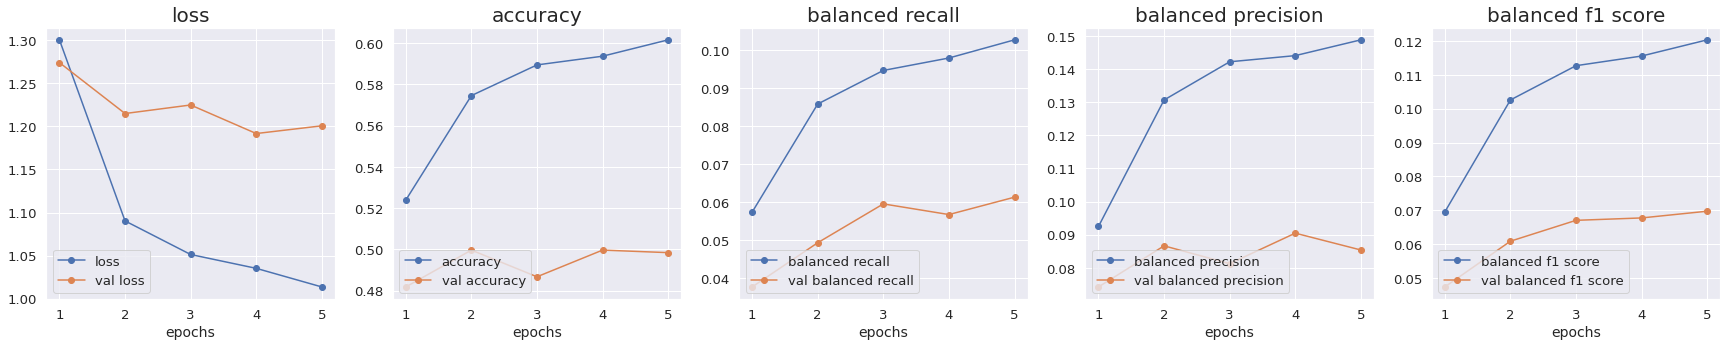

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

### Inter2

In [ ]:
# Target
# y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)
target_train = tf.keras.utils.to_categorical(df_train['INTER2'].values, num_classes=num_classes)
target_valid = tf.keras.utils.to_categorical(df_valid['INTER2'].values, num_classes=num_classes)

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(len(event_type_int_map), activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 5

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 83s 130ms/step - loss: 1.2748 - accuracy: 0.5484 - balanced_recall: 0.0618 - balanced_precision: 0.0837 - balanced_f1_score: 0.0699 - val_loss: 1.2540 - val_accuracy: 0.5562 - val_balanced_recall: 0.0423 - val_balanced_precision: 0.0642 - val_balanced_f1_score: 0.0492
Epoch 2/5
607/607 [==============================] - 77s 127ms/step - loss: 1.0806 - accuracy: 0.6199 - balanced_recall: 0.0830 - balanced_precision: 0.1106 - balanced_f1_score: 0.0939 - val_loss: 1.2153 - val_accuracy: 0.5650 - val_balanced_recall: 0.0517 - val_balanced_precision: 0.0706 - val_balanced_f1_score: 0.0584
Epoch 3/5
607/607 [==============================] - 86s 142ms/step - loss: 1.0397 - accuracy: 0.6338 - balanced_recall: 0.0909 - balanced_precision: 0.1206 - balanced_f1_score: 0.1028 - val_loss: 1.1719 - val_accuracy: 0.5751 - val_balanced_recall: 0.0534 - val_balanced_precision: 0.0784 - val_balanced_f1_score: 0.0619
Epoch 4/5
607/607 [===============

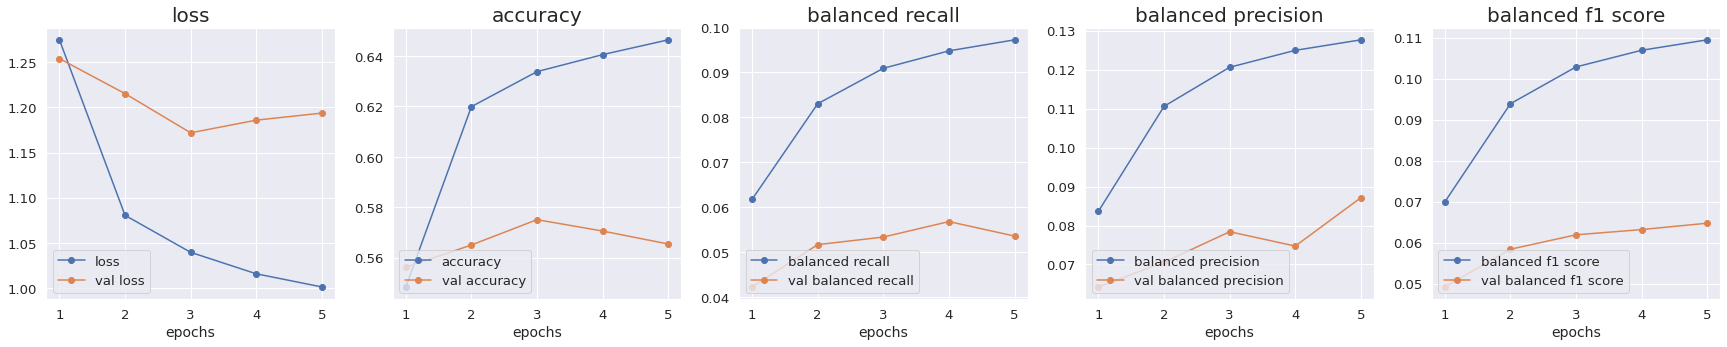

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

## Fatalities

In [ ]:
# Target
target_train = float(df_train['FATALITIES'])
target_valid = float(df_valid['FATALITIES'])

{'Remote explosive/landmine/IED': 0, 'Attack': 1, 'Armed clash': 2, 'Agreement': 3, 'Violent demonstration': 4, 'Peaceful protest': 5, 'Mob violence': 6, 'Sexual violence': 7, 'Protest with intervention': 8, 'Arrests': 9, 'Grenade': 10, 'Abduction/forced disappearance': 11, 'Disrupted weapons use': 12, 'Government regains territory': 13, 'Air/drone strike': 14, 'Non-state actor overtakes territory': 15, 'Excessive force against protesters': 16, 'Shelling/artillery/missile attack': 17, 'Suicide bomb': 18, 'Headquarters or base established': 19, 'Looting/property destruction': 20, 'Change to group/activity': 21, 'Non-violent transfer of territory': 22, 'Other': 23}


In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(len(event_type_int_map), activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 5

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 173s 258ms/step - loss: 1.0230 - accuracy: 0.6056 - balanced_recall: 0.3200 - balanced_precision: 0.4655 - balanced_f1_score: 0.3744 - val_loss: 0.8787 - val_accuracy: 0.6289 - val_balanced_recall: 0.2801 - val_balanced_precision: 0.3730 - val_balanced_f1_score: 0.3161
Epoch 2/5
607/607 [==============================] - 154s 254ms/step - loss: 0.7936 - accuracy: 0.6946 - balanced_recall: 0.4738 - balanced_precision: 0.6066 - balanced_f1_score: 0.5294 - val_loss: 0.7650 - val_accuracy: 0.6919 - val_balanced_recall: 0.3418 - val_balanced_precision: 0.4377 - val_balanced_f1_score: 0.3801
Epoch 3/5
607/607 [==============================] - 154s 254ms/step - loss: 0.7478 - accuracy: 0.7140 - balanced_recall: 0.5105 - balanced_precision: 0.6355 - balanced_f1_score: 0.5640 - val_loss: 0.7878 - val_accuracy: 0.6693 - val_balanced_recall: 0.3466 - val_balanced_precision: 0.4405 - val_balanced_f1_score: 0.3841
Epoch 4/5
607/607 [============

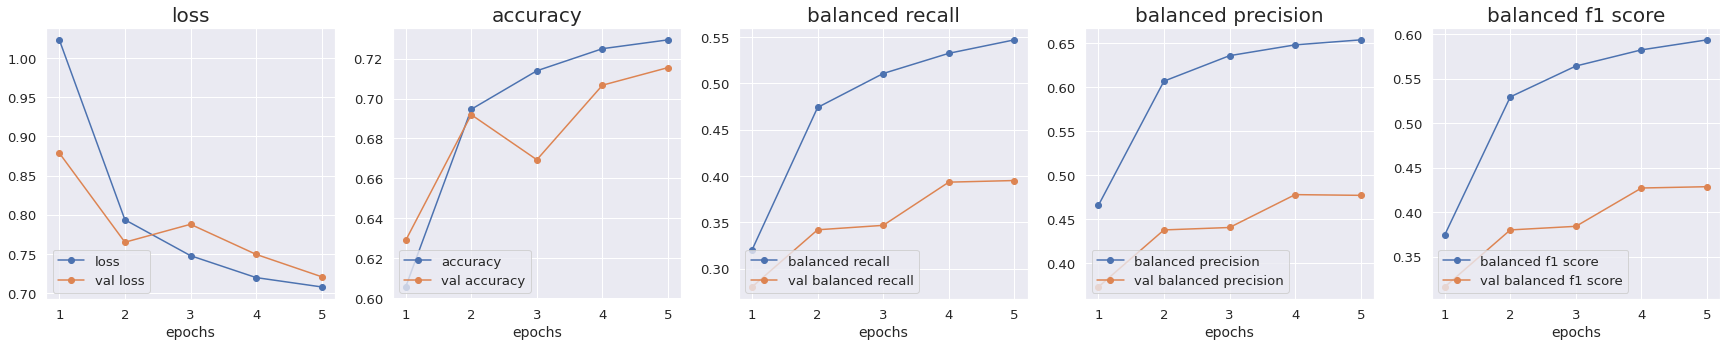

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

## arch

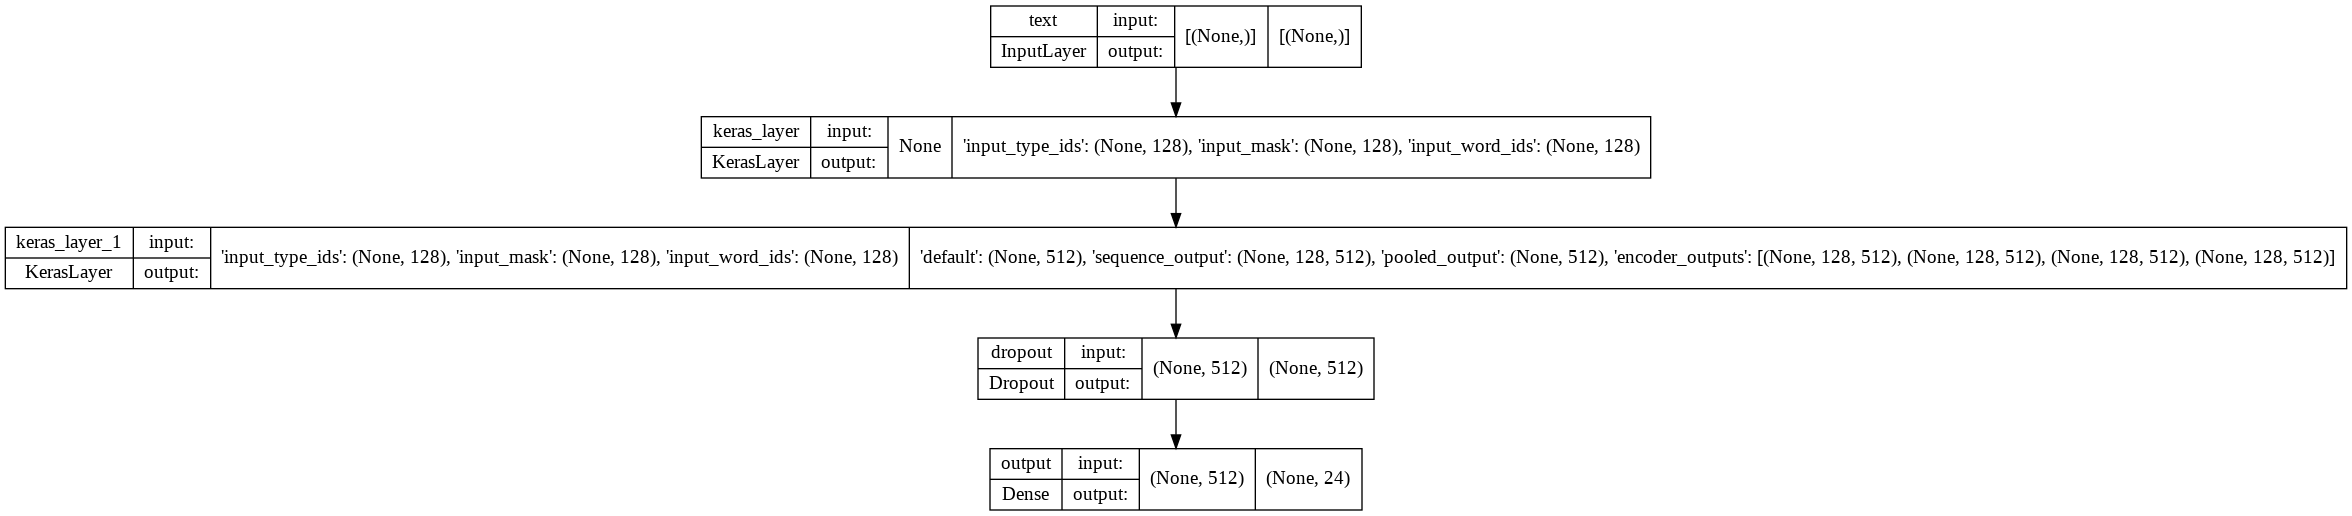

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="Multiclass categorical.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)